In [1]:
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import pickle 
import pandas as pd
#from sklearnex import patch_sklearn
#patch_sklearn()

from scipy import special
import os

from time import time 
from scipy import interpolate

import corner

from pymultinest.solve import solve, run
import matplotlib.pyplot as plt
%matplotlib inline
# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
plt.rcParams['figure.figsize'] = (9, 6)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
colormap={0:'red',1:'green'}
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True 
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['font.size'] = 12

import json


#loading observations
from PyAstronomy import pyasl
from observation import load_observations
from chi_computations import chi_window,chi_squared,chi_squared_reduced
from para_transform import para_to_parameterin
from rout import adjust_rout
from data_prep import load_para_input
from dict_f import log_dict
from star_hrd import *


2023-09-06 11:50:23.004814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

name='single_46_opti'


name_incl='shielded_single_04'
#name='single_23_wo_wrongall3'
#name='single_42_onlyshortmodels_200' # what network to use
star_name='star_m-only_3' #what network for mass prediction of star
path_data='./data/' #where is the downloaded data
bayesian_folder='./Output/' #output data folder


dereddeningdata=False
#file_name='SEDobs.dat'

new_data=True




# stars in hrd?

In [3]:
p0_list=np.log10(np.logspace(3.45,4.1,10))
#print(p0_list)
p1_list=np.log10(np.logspace(-2,1.9,10))
for temp in p0_list:
    for lum in p1_list:
        print(check_if_in(temp,lum))
        if check_if_in(temp,lum):
            print(temp,lum)

False
False
False
False
False
False
False
False
False
False
False
False
True
3.522222222222222 -1.1333333333333333
True
3.522222222222222 -0.7
True
3.522222222222222 -0.2666666666666666
False
False
False
False
False
False
False
False
True
3.5944444444444446 -0.7
True
3.5944444444444446 -0.2666666666666666
True
3.5944444444444446 0.16666666666666696
False
False
False
False
False
False
False
False
True
3.6666666666666665 -0.2666666666666666
True
3.6666666666666665 0.16666666666666696
True
3.6666666666666665 0.6000000000000001
True
3.6666666666666665 1.0333333333333332
False
False
False
False
False
False
False
False
True
3.738888888888889 0.6000000000000001
True
3.738888888888889 1.0333333333333332
False
False
False
False
False
False
False
False
True
3.811111111111111 0.6000000000000001
True
3.811111111111111 1.0333333333333332
True
3.811111111111111 1.4666666666666668
False
False
False
False
False
False
False
False
True
3.8833333333333333 1.0333333333333332
True
3.8833333333333333 1.4666

# model function

In [4]:
scaler=joblib.load(f'{path_data}/scaler/{name}_para_scaler.save')
y_scaler=joblib.load(f'{path_data}/scaler/{name}_sed_scaler.save')

/home/tkaeufer/anaconda3/envs/edward/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
model_saved=load_model(f'{path_data}/NeuralNets/{name}.h5',compile=False)


2023-09-06 11:50:30.298237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 81 MB memory:  -> device: 0, name: Quadro P400, pci bus id: 0000:21:00.0, compute capability: 6.1


In [6]:
#inclination neural nets that tells if a star is shielded and therefore excluded from our analysis

lim_shielded=0.072104424

incl_scaler=joblib.load(f'{path_data}/scaler/{name_incl}_para_scaler.save')
incl_y_scaler=joblib.load(f'{path_data}/scaler/{name_incl}_sed_scaler.save')
try:
    incl_model_saved=load_model(f'{path_data}/NeuralNets/{name_incl}.h5',compile=False)
except:
    incl_model_saved=load_model(f'{path_data}/{name_incl}.h5',compile=False)


/home/tkaeufer/anaconda3/envs/edward/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
txt=str()
with open(f'./data/wavelength.out','r') as f:
    lines=f.readlines()
for line in lines[1:]:
    
    txt=txt+line.strip()+' '  
txt=txt[1:-2].split()
wavelength=np.array(txt,'float64')
  

In [8]:
header=np.load(f'./data/header.npy')
header=np.concatenate((header,['incl']),axis=0)
print(header)

['Mstar' 'Lstar' 'Teff' 'fUV' 'pUV' 'amin' 'amax' 'apow' 'a_settle'
 'Mg0.7Fe0.3SiO3[s]' 'amC-Zubko[s]' 'fPAH' 'PAH_charged' 'Mdisk' 'Rin'
 'Rtaper' 'Rout' 'epsilon' 'MCFOST_H0' 'MCFOST_BETA' 'incl']


In [9]:
class NN_star:
    def __init__(self,star_name=star_name,path_starNN_data=path_data+'/star_NN'):
        self.scaler=joblib.load(f'{path_starNN_data}/scaler/{star_name}_input_scaler.save')
        '''
        input scaler
        '''
        self.yscaler=joblib.load(f'{path_starNN_data}/scaler/{star_name}_output_scaler.save')
        '''
        output scaler
        '''
        self.NN=load_model(f'{path_starNN_data}/{star_name}.h5',compile=False)
        
    def predict_stellar_mass(self,temp,lum):
        '''
        temp and lum on log10 scale
        '''

        input_NN=self.scaler.transform(np.expand_dims(np.array([temp,lum]),0))
        output_NN=self.NN(input_NN)
        mass=self.yscaler.inverse_transform(output_NN)[0][0]
        return 10**mass

In [10]:
NN_stellar=NN_star()

/home/tkaeufer/anaconda3/envs/edward/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# excluding the parameters that are derived


In [11]:
delete_derived_paras=True
if delete_derived_paras:
    list_derived=['Mstar', 'amC-Zubko[s]', 'Rout']
    len_new_header=len(header)-len(list_derived)
    new_header_1=[]
    i_list=[]
    for i in range(len(header)):
        if header[i] not in list_derived:
            new_header_1.append(header[i])
            i_list.append(i)
    new_header_1=np.asarray(new_header_1)
    

# fixing parameters

In [12]:

def angle_to_mcfost_val(angle):
    rad=angle*np.pi/180
    cosx=np.cos(rad)
    mcfost_incl=10-(cosx-0.05)/0.1-1    
    return mcfost_incl
    
def transform_parameters(features):
    if 'incl' not in list_fixed:
        features[idx_incl]=angle_to_mcfost_val(features[idx_incl])
    features=np.expand_dims(features,0)
    #for i in range(len(header)):
    #    if log_dict[header[i]]=='log':
    #        features[0,i]=np.log10(features[0,i])
    scaled_f=scaler.transform(features)
    return scaled_f


def incl_NN(features):
    #print('SHAPE',np.shape(features))
    if 'incl' not in list_fixed:
        features[idx_incl]=angle_to_mcfost_val(features[idx_incl])
    features=np.expand_dims(features,0)
    #print('INCL MCFOST',features[idx_incl])
    #for i in range(len(header)):
    #    if log_dict[header[i]]=='log':
    #        features[0,i]=np.log10(features[0,i])
    scaled_f=incl_scaler.transform(features)
    
    incl_prediction=incl_model_saved(scaled_f,training=False)
    
    return incl_prediction
def change_dist(dist,data):
    new_data=data*(100/dist)**2
    return new_data
    
def reddening( lam,flux, e_bv, R_V):
        # lam in mu m 
        fluxRed = pyasl.unred(lam*10**4, flux, ebv=-e_bv, R_V=R_V)
        return fluxRed

In [13]:
angle_to_mcfost_val(18)

-0.010565162951534646

# defining all the functions that are needed

### model function
input: features

process: Neural net prediction + reddening + distance scaling

output: sed

In [14]:

def model(feat):
    #print('start model')
    #print('start array')
    #print(time())
    #print(feat)
    #print('start transform')
    #print(time())
    X_in=transform_parameters(feat)
    #print(time())
    #print('prediction')
    #start=time()
    pred=model_saved(X_in,training=False)
    #end=time()
    #print(end-start)
    #print('Re transform')
    #print(time())

    data=10**(y_scaler.inverse_transform(pred))[0]
    #print('start distance')
    #print(time())
    data=change_dist(dist,data)
    #print('start reddening')
    #print(time())
    data=reddening(wavelength,data,e_bv,R_V)
    
    plot=False
    if plot:
        plt.figure()
        plt.scatter(wavelength,data)
        plt.xscale('log')
        plt.yscale('log')
        plt.grid()
        plt.xlabel(r'$ \lambda \, [\mu m]$')
        plt.ylabel(r'$ \nu F_\nu [erg/cm^2/s]$')
        plt.show()
    return data

### Interpolate the fluxes to the right wavlength

In [15]:
def spline(lam,nuflux,new_lam):

    #interpolation on a double logarithmic scale
    s=interpolate.InterpolatedUnivariateSpline(np.log10(lam),np.log10(nuflux))
    interp=10**(s(np.log10(new_lam)))
#    return interp #returning the nex SED
    return interp #for visualisation



In [16]:
def lin_interp(lam,nuflux,new_lam):
    exp=np.interp(np.log10(new_lam),np.log10(lam),np.log10(nuflux))
    
    interp=10**exp
#    return interp #returning the nex SED
    return interp #for visualisation



plotting the sed

In [17]:
def plot_sed_residual(y_true,y_predict,wavelength=wavelength,residual='Normal'):
    fig = plt.figure(figsize=(9,9))
    gs = fig.add_gridspec(3, 1)
    f_ax1 = fig.add_subplot(gs[0:2, :])
    f_ax1.scatter(wavelength,y_true,label='Observation',marker='+')
    f_ax1.scatter(wavelength,y_predict,label='Prediction',marker='+')

    f_ax1.set_xscale('log')
    f_ax1.set_yscale('log')
    f_ax1.grid()
    f_ax1.legend()
    f_ax1.set_xlabel(r'$ \lambda \, [\mu m]$')
    f_ax1.set_ylabel(r'$ \nu F_\nu [erg/cm^2/s]$')
    f_ax2 = fig.add_subplot(gs[2, :])
#     f_ax2.set_title('Residual')
#    f_ax2.plot(position,(np.log10(y_true[x])-np.log10(y_predict[x]))/np.log10(y_true[x]),marker='+',linestyle='none',label='Residual',color='tab:orange')
    if residual=='Normal':
        diff=(np.log10(y_true)-np.log10(y_predict))
        f_ax2.set_ylabel(r'$ log(F_{true})-log(F_{predict})$')
    if residual=='Ribas':
        diff=(y_true-y_predict)/y_true *100
        f_ax2.set_ylabel(r'$ (F_{true}-F_{predict})/F_{true}$ [%]')

    f_ax2.plot(wavelength,diff,marker='+',linestyle='none',label='Residual',color='tab:orange')
    f_ax2.axhline(0,label='Perfect Prediction',color='tab:blue')
    #    f_ax2.set_ylabel(r'$ (log(F_{true})-log(F_{predict}))/log(F_{true})$')
    f_ax2.set_xlabel(r'$ \lambda \, [\mu m]$')
    f_ax2.set_xscale('log')   
    f_ax2.grid()
    f_ax2.legend()
    plt.tight_layout()
    plt.show()

### combining everything in the loglike function

input: parameters

process: Model function + interpole flux + calculate loglike

output: loglike

In [18]:
uncertainty_nn=0.05
def loglike(cube,model_uncertainty=True,debug=False):
    if check_physics_and_training:
        if fixed_paras:
            feat=np.zeros(len(new_header_1))
            feat[idx_fixed]=value_fixed
            feat[idx_unfixed]=cube
        else:
            feat=cube
        #checks due to physical reasons
        #check if maximum dust size is larger than minimal of the inner zone
        if feat[idx_amin]>=feat[idx_amax]:
            #print('amain/amax')
            if debug:
                print('Fail amin max',feat[idx_amin],feat[idx_amax])
            return -10**10 #this needs to be a small value

        #check if taper radius is larger than inner radius
        if feat[idx_rin]>=feat[idx_rtaper]: # for single zone this is without 10**
            #print('Rin/Rtaper')
            if debug:
                print('Fail rin rtaper',feat[idx_rin],feat[idx_rtaper])
            return -10**10 #this needs to be a small value
        
        #checking if the star is shielded
        shield_val=incl_NN(feat)
        #print(shield_val)
        #print(np.shape(shield_val))
        if shield_val>=lim_shielded:
            if debug:
                print('Fail shielded')
            return -10**10 #this needs to be a small value     
        
        #checking if the star is possible
        temp=feat[idx_teff]
        lum=feat[idx_lstar]
        if not check_if_in(temp,lum):
            if debug:
                print('Fail star',temp,lum)
            return -10**10 #this needs to be a small value     
            
            
        # checking if the inner disk radius is possible
        if debug:
            print('Temp,Lum',temp,lum)
        rmin,rmax=new_radius_lims(teff=10**temp,lstar=10**lum)
        if debug:
            print('Radius min max and value',rmin,rmax,feat[idx_rin])
        
        if feat[idx_rin]<rmin or feat[idx_rin]>rmax:
            if debug:
                print('Fail Radius')

            return -10**10 #this needs to be a small value     
            
        #check if disk mass is valid
        
        stellar_mass=NN_stellar.predict_stellar_mass(temp=temp,lum=lum)
        mdisk_min,mdisk_max=mdisk_lims_mstar(stellar_mass)    
        if debug:
            print('Mass of disk',mdisk_min,mdisk_max,feat[idx_mdisk])

        if feat[idx_mdisk]<mdisk_min or feat[idx_mdisk]>mdisk_max:
            if debug:
                print('Fail Mass of disk',mdisk_min,mdisk_max,feat[idx_mdisk])

            return -10**10 #this needs to be a small value     
        
    #calculate model
    #print('Model start')
    #print(time())
    #start=time()
    ymodel = model(feat)
    #print('Model end')
    #print(time())
    #include constante model uncertainy?
    
    #try:
    #interpolate flux
    #print('start interp')
    #print(time())
    interp_flux=spline(wavelength,ymodel,lam_obs)
    #interp_flux=lin_interp(wavelength,ymodel,lam_obs)
    #print('calc')
    #print(time())
    
    #plot_sed_residual(flux_obs,interp_flux,wavelength=lam_obs,residual='Normal')
    if model_uncertainty:
        model_sig=uncertainty_nn*interp_flux
        sigma=(np.sqrt(sig_obs**2+model_sig**2))
                    
    else:
        sigma=sig_obs

    # constant of loglike
    const=np.sum(weights*np.log(2*np.pi*(sigma)**2))

    #difference between observation and model
    diff=(interp_flux - flux_obs)

    #definition of chi
    chi=np.sum( weights*(diff)**2/ sigma**2)

    #loglike
    loglikelihood =  -0.5 * (chi +const) 
    #except:
    #    return -np.inf
    #end=time()
    #print(end-start)

    if not np.isfinite(loglikelihood):
        return -np.inf
    else:
        return loglikelihood

# priors

In [19]:

header3,matched_para3=load_para_input(f'{path_data}/sample_data/single_zone_4')
header2,matched_para2=load_para_input(f'{path_data}/sample_data/single_zone_2')


Shape of header:
(21,)
Shape of parameter file:
(220934, 21)
Shape of header:
(21,)
Shape of parameter file:
(451230, 21)


In [20]:
matched_para=np.concatenate((matched_para2,matched_para3),axis=0)

para_input_del=np.zeros_like(matched_para)
print('Transforming Parameters: \n')
for x in range(len(header)):  
    print(header[x])
    if log_dict[header[x]]=='log':
        para_input_del[:,x]=np.log10(matched_para[:,x]) #make log
    elif log_dict[header[x]]=='linear':
        para_input_del[:,x]=matched_para[:,x] #original value
    else:
        print('Failed')
        

Transforming Parameters: 

Mstar
Lstar
Teff
fUV
pUV
amin
amax
apow
a_settle
Mg0.7Fe0.3SiO3[s]
amC-Zubko[s]
fPAH
PAH_charged
Mdisk
Rin
Rtaper
Rout
epsilon
MCFOST_H0
MCFOST_BETA
incl


In [21]:
def prior(cube):
    
    #this is a uniform prior in log or normal space between the highest and lowest value present in the grid
    new_cube=np.zeros_like(cube)
    for i in range(len(cube)):
        new_cube[i]=(cube[i])*(upper_lim[i]-lower_lim[i])+lower_lim[i]
    return new_cube

In [22]:
def find_idx_fixed():
    fixed_idx=[]
    value_fixed=[]
    unfixed_idx=[]
    for i in range(len(new_header_1)):
        if new_header_1[i] not in  new_header:
            print(new_header_1[i])
            for k in range(len(list_fixed)):
                if list_fixed[k]==new_header_1[i]:
                    fixed_idx.append(i)
                    value_fixed.append(dict_fix[list_fixed[k]])
        else:
            unfixed_idx.append(i)
    unfixed_idx=np.asarray(unfixed_idx)
    fixed_idx=np.asarray(fixed_idx)
    value_fixed=np.asarray(value_fixed)
    return fixed_idx,unfixed_idx,value_fixed

In [23]:
def prior_multinest(cube):
    scaled_cube=np.zeros_like(cube)
    #this is a uniform prior in log or normal space between the highest and lowest value present in the grid
    for i in range(len(cube)):
        scaled_cube[i]=cube[i]*(upper_lim[i]-lower_lim[i])+lower_lim[i]
    return scaled_cube

### combining priors and loglike function

In [24]:
def log_probability(cube):
    lp = lg_prior(cube)
    if not np.isfinite(lp):
        return -np.inf
    return loglike(cube)
    

In [25]:
def fixing_paras(list_fixed=['Lstar','Teff','fUV','pUV','incl'] ,fixed_paras=True):

    if fixed_paras:
        len_new_header=len(new_header_1)-len(list_fixed)
        new_header=[]
        j_list=[]
        for i in range(len(new_header_1)):
            if new_header_1[i] not in list_fixed:
                new_header.append(new_header_1[i])
                j_list.append(i)
        new_header=np.asarray(new_header)
    else:
        new_header=new_header_1
    if 'incl' not in list_fixed:
        idx_incl=np.where(new_header=='incl')[0][0]
    if 'Rin' not in list_fixed:
        idx_rin_new=np.where(new_header=='Rin')[0][0]
    if 'Mdisk' not in list_fixed:
        idx_mdisk_new=np.where(new_header=='Mdisk')[0][0]

        #print(idx_incl)
    if fixed_paras:
        len_new_header=len(new_header)
        para_input2= np.zeros((len(para_input_del),len_new_header))
        for j in range(len(new_header)):
            if new_header[j] in header2:
                idx_head=np.where(np.array(header2==new_header[j]))[0][0]
                para_input2[:,j]=para_input_del[:,idx_head]

        para_input=para_input2
        print()
        print('New shape')
        print(np.shape(para_input))
    else:
        len_new_header=len(header)-len(list_derived)
        para_input2= np.zeros((len(para_input_del),len_new_header))
        for j in range(len(new_header)):

            if header[i_list[j]] in list_derived:
                print('PROBLEM')
            para_input2[:,j]=para_input_del[:,i_list[j]]

        para_input=para_input2
        print()
        print('New shape')
        print(np.shape(para_input))
        
    lower_lim=np.min(para_input,axis=0)
    print(np.shape(lower_lim))
    upper_lim=np.max(para_input,axis=0)
    print(np.shape(upper_lim))
    if 'incl' not in list_fixed:
        upper_lim[idx_incl]=87
        lower_lim[idx_incl]=18
        
    

    args=[]
    for head in new_header:
        if log_dict[head]=='log':
            head='log(' + head+')'
        args.append(head)
    #print(args)
    
    return list_fixed, new_header,lower_lim,upper_lim,args

In [26]:
def get_idxes(new_header_1):

    idx_rin=np.where(new_header_1=='Rin')[0][0]
    idx_amax=np.where(new_header_1=='amax')[0][0]
    idx_amin=np.where(new_header_1=='amin')[0][0]

    idx_fpah=np.where(new_header_1=='fPAH')[0][0]

    # these are all parameters we need for a smooth inner disk

    idx_h0=np.where(new_header_1=='MCFOST_H0')[0][0]
    idx_mcfost_b=np.where(new_header_1=='MCFOST_BETA')[0][0]
    idx_mdisk=np.where(new_header_1=='Mdisk')[0][0]
    idx_rtaper=np.where(new_header_1=='Rtaper')[0][0]
    idx_epsilon=np.where(new_header_1=='epsilon')[0][0]
    idx_teff=np.where(new_header_1=='Teff')[0][0]
    idx_lstar=np.where(new_header_1=='Lstar')[0][0]


    print(idx_rin,idx_amax,idx_fpah)
    print(idx_h0,idx_rin,idx_mcfost_b)
    print(idx_mdisk,idx_rtaper,idx_epsilon)

    return idx_rin, idx_rtaper, idx_amin, idx_amax, idx_fpah, idx_h0, idx_mdisk, idx_epsilon, idx_mcfost_b,idx_teff,idx_lstar

In [27]:
def gauss_limit_scaling(x_mean,x_std,x_min,x_max,n_sample,log=False):    
    #rand=np.random.rand(n_sample,2)
    rand0=np.arange(0,1,1/n_sample)
    rand1=np.arange(0,1,1/n_sample)
    size_rand=len(rand0)
    np.random.seed(1234)
    rand_int=np.random.choice(n_sample,size=size_rand,replace=False)
    rand1=rand1[rand_int]
    rand=np.zeros((n_sample,2))
    rand[:,0]=rand0
    rand[:,1]=rand1
    ptp=x_max-x_min
    value=np.zeros(len(rand))

    div=np.sqrt(2)*special.erfinv(1-2*rand[:,0])
    value=(x_mean+x_std*div)
    for j in range(len(div)):
        if value[j] > x_max  or value[j] < x_min:
            value[j]=rand[j,1]*ptp + x_min
        
    return value

In [28]:
def new_radius_distribution(teff,lstar,n_sample):
    '''
    We use the sublimation temperature limits that we have in the training grid to limit the possible rins/ r2ins.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    hplanck = 6.62607554E-27        # Planck's constant
    bk      = 1.38065812E-16        # Boltzmann's constant
    cl      = 2.99792458E+10        # speed of light
    pi=np.pi
    cPl1    = 2.0*hplanck*cl**2
    cPl2    = hplanck*cl/bk
    sig_SB  = cPl1/cPl2**4*pi**5/15.0
    Lsun    = 3.8260E+33            # solar luminosity
    Msun    = 1.9889225E+33         # solar mass
    Rsun    = 6.9599000E+10         # solar radius
    Rsun_to_AU=214.939
    tsub_max=1677
    tsub_min=100
    tsub_mean=1333
    tsub_std=457
    
    
    tsub=gauss_limit_scaling(tsub_mean,tsub_std,tsub_min,tsub_max,n_sample)        

    #calculating_rstar
    
    rstar = np.sqrt(lstar*Lsun/(4.0*pi*sig_SB*teff**4)) /Rsun /Rsun_to_AU
    
    rsubs=np.zeros(n_sample)
    rsubs=np.sqrt(1-0.2)* (teff/tsub)**2 * rstar
    
    return np.log10(rsubs)

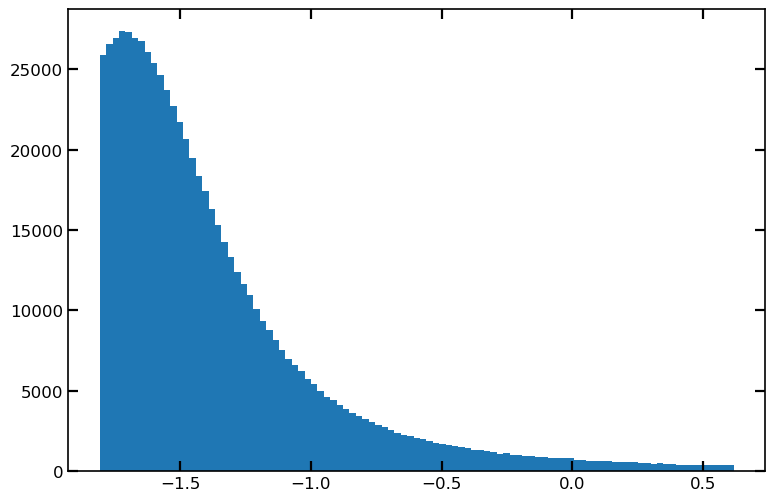

In [29]:
rsub=new_radius_distribution(3000,0.1,len(para_input_del))

bins=np.arange(np.min(rsub),np.max(rsub),np.ptp(rsub)/100)

#logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(rsub,bins)
#plt.xscale('log')
plt.show()

In [30]:
def new_radius_lims(teff,lstar):
    '''
    We use the sublimation temperature limits that we have in the training grid to limit the possible rins/ r2ins.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    hplanck = 6.62607554E-27        # Planck's constant
    bk      = 1.38065812E-16        # Boltzmann's constant
    cl      = 2.99792458E+10        # speed of light
    pi=np.pi
    cPl1    = 2.0*hplanck*cl**2
    cPl2    = hplanck*cl/bk
    sig_SB  = cPl1/cPl2**4*pi**5/15.0
    Lsun    = 3.8260E+33            # solar luminosity
    Msun    = 1.9889225E+33         # solar mass
    Rsun    = 6.9599000E+10         # solar radius
    Rsun_to_AU=214.939
    tsub_max=1677
    tsub_min=100
    
    #calculating_rstar
    
    rstar = np.sqrt(lstar*Lsun/(4.0*pi*sig_SB*teff**4)) /Rsun /Rsun_to_AU
    
    
    rmin=np.sqrt(1-0.2)* (teff/tsub_max)**2 * rstar
    rmax=np.sqrt(1-0.2)* (teff/tsub_min)**2 * rstar
    
    rmin=np.log10(rmin)
    rmax=np.log10(rmax)
    return rmin, rmax

In [31]:
def mdisk_lims_mstar(mstar):
    '''
    We use the mdisk limits that we have in the training grid for a certain mstar.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    #print(mstar)
    mdisk_to_mstar_max=1
    mdisk_to_mstar_min=10**(-5)
    
    mdisk_min=mdisk_to_mstar_min*mstar
    mdisk_max=mdisk_to_mstar_max*mstar
    
    #print(mdisk_min,mdisk_max)   
    mdisk_min=np.log10(mdisk_min)
    mdisk_max=np.log10(mdisk_max)
    return mdisk_min, mdisk_max

In [32]:
def new_mdisk_lims(ob):
    '''
    We use the mdisk limits that we have in the training grid for a certain mstar.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    mstar=get_para_from_Parameterin(ob,['Mstar'])[0]
    print(mstar)
    mdisk_to_mstar_max=1
    mdisk_to_mstar_min=10**(-5)
    
    mdisk_min=mdisk_to_mstar_min*mstar
    mdisk_max=mdisk_to_mstar_max*mstar
    
    print(mdisk_min,mdisk_max)   
    mdisk_min=np.log10(mdisk_min)
    mdisk_max=np.log10(mdisk_max)
    return mdisk_min, mdisk_max

In [33]:
def new_mdisk_distribution(mstar,n_sample):
    '''
    We use the mdisk limits that we have in the training grid for a certain mstar.
    Since all stellar parameters are fixed we can simply calculte the new limits before the MultiNest run and adjust the prior
    '''
    
    m_mean=-2
    m_min=-5
    m_max=0
    m_std=0.8
    
    m_dist=gauss_limit_scaling(m_mean,m_std,m_min,m_max,n_sample)        

    m_dist=m_dist+np.log10(mstar)
    return m_dist

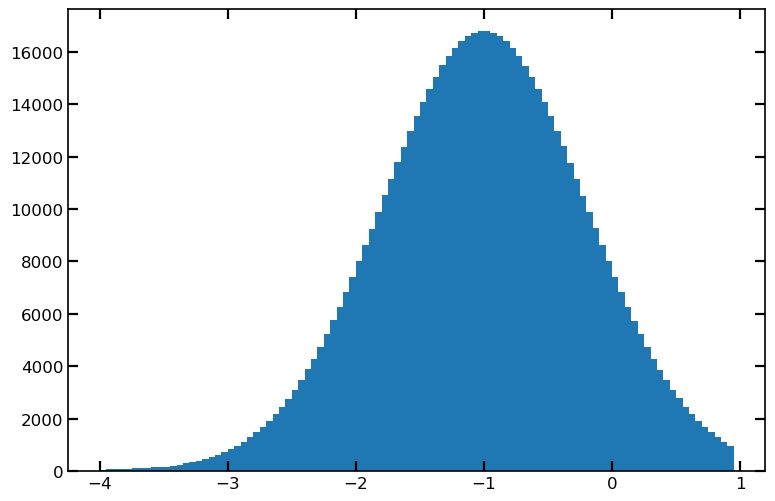

In [34]:
m_dist=new_mdisk_distribution(10,len(para_input_del))
bins=np.arange(np.min(m_dist),np.max(m_dist),np.ptp(m_dist)/100)
plt.hist(m_dist,bins)
plt.show()

In [35]:
# creating the same prior as used in the sample

print(np.shape(para_input_del),np.shape(header))


len_array=len(para_input_del)
idxs_array=np.arange(len_array)
def prior_sampling(cube):
    scaled_cube=np.zeros_like(cube)
    #this is a uniform prior in log or normal space between the highest and lowest value present in the grid
    for i in range(len(cube)):
        scaled_cube[i]=np.interp(cube[i]*len_array,idxs_array,sorted_sample[:,i])
        
    return scaled_cube

def lin_interp_sample(rand,len_array,valuearray):
    rand_scaled=rand*len_array
    val=np.interp(rand_scaled,np.arange(len(valuearray)),valuearray)
    return val



rand=0.0080
len_array=len(para_input_del)
for i in range(np.shape(para_input_del)[1]):
    print(header[i])
    sorted_para=np.sort(para_input_del[:,i])
    val=lin_interp_sample(rand,len_array,valuearray=sorted_para)
    print(val)

(672164, 21) (21,)
Mstar
-0.686507193194684
Lstar
-1.3762843633884083
Teff
3.4941532688614636
fUV
-2.972447732472563
pUV
-0.7906772099075052
amin
-2.8334179570326277
amax
2.604561745302028
apow
3.02498588
a_settle
-4.775736936491063
Mg0.7Fe0.3SiO3[s]
0.462259014
amC-Zubko[s]
0.0667054061
fPAH
-3.3737029949673465
PAH_charged
0.00788562838
Mdisk
-4.216625429888308
Rin
-1.801348732080879
Rtaper
0.7250557460953672
Rout
1.533127380887636
epsilon
0.119634597
MCFOST_H0
3.19142264
MCFOST_BETA
0.973784681
incl
0.0


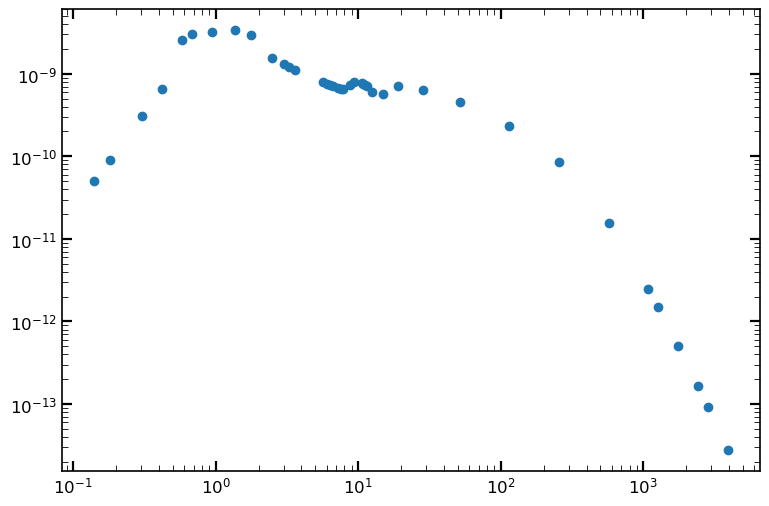

Lstar 1.7378
log
Teff 4365.16
log
fUV 0.026915
log
pUV 0.954993
log
amin 0.031623
log
amax 3981.07
log
apow 3.6
a_settle 0.001
log
Mg0.7Fe0.3SiO3[s] 0.57
fPAH 0.031623
log
PAH_charged 0.5
Mdisk 0.042954
log
Rin 0.199526
log
Rtaper 89.1251
log
epsilon 1.0
MCFOST_H0 12.0
MCFOST_BETA 1.15
incl 0.103074
E(B-V) 0.1
R(V) 3.1
Dist[pc] 100.0


In [36]:
data=np.loadtxt('./mock_flux.txt',skiprows=1)
lam_obs=data[:-1,0]
flux_obs=data[:-1,1]
sig_obs=data[:-1,2]

idx_list=[10,15,20,22,24,25,27,30,32,35,37,40,45,50,52,55,57,60,62,65,76,70,72,75,77,80,85,90,95,100,105,110,115,120,124,125,127,129,130,132]
lam_obs=lam_obs[idx_list]
flux_obs=flux_obs[idx_list]
sig_obs=sig_obs[idx_list]

plt.scatter(lam_obs,flux_obs)
plt.xscale('log')
plt.yscale('log')
plt.show()
dict_mock={}
with open('./mock_para.txt','r') as f:
    lines=f.readlines()
    for line in lines:
        line_sp=line.split()
        para=line_sp[1]
        val=float(line_sp[0])
        print(para,val)
        if para in log_dict and log_dict[para]=='log':
            print('log')
            val=np.log10(val)
        dict_mock[para]=val
        

In [37]:
dict_mock

{'Lstar': 0.23999979288687143,
 'Teff': 3.6400001669061024,
 'fUV': -1.5700056158482933,
 'pUV': -0.019999811738258863,
 'amin': -1.4999969319483069,
 'amax': 3.59999981394342,
 'apow': 3.6,
 'a_settle': -3.0,
 'Mg0.7Fe0.3SiO3[s]': 0.57,
 'fPAH': -1.4999969319483069,
 'PAH_charged': 0.5,
 'Mdisk': -1.3669963871985225,
 'Rin': -0.7000005038830162,
 'Rtaper': 1.9500000301465847,
 'epsilon': 1.0,
 'MCFOST_H0': 12.0,
 'MCFOST_BETA': 1.15,
 'incl': 0.103074,
 'E(B-V)': 0.1,
 'R(V)': 3.1,
 'Dist[pc]': 100.0}

In [ ]:
ob=''

check_physics_and_training=True
min_wave=0.5
subfold='Example_mock/'
run_number=2
#sing_obs=['49Cet','DNTau','FTTau','RULup', 'MWC480', 'RECX15','DOTau', 'DFTau']  #, , ] the last one has no propper UV fit
#two_obs=['AATau', 'ABAur', 'BPTau', 'CITau', 'CYTau', 'DMTau', 'GMAur', 'HD100546', 'HD135344B', 'HD142666', 'HD163296', 'HD169142', 'HD95881', 'HD97048', 'LkCa15', 'RYLup', 'TWCha', 'TWHya', 'UScoJ1604-2130', 'V1149Sco']
#all_obj=['DOTau']#all_obj=['49Cet','AATau','DNTau']
fixed_paras=True
#all_obj=['HD163296']
#objects=all_obj#[ 'DOTau']#[ 'DOTau']#,'RECX15']#, 'DOTau', 'RECX15', 'RULup'] #'DFTau', 'FTTau', 'MWC480',
sample_prior=False

use_fix_reddening=True
weight=True

running=True

input_list_fix=['fUV','pUV']


fold_string=bayesian_folder
if subfold!='':
    os.system(f'mkdir {fold_string}{subfold}')
    fold_string=fold_string+subfold
    
    
    
'''
RESTRICT
'''
restrict_alpha=True
    
idx_rin, idx_rtaper, idx_amin, idx_amax, idx_fpah, idx_h0, idx_mdisk, idx_epsilon, idx_mcfost_b,idx_teff,idx_lstar= get_idxes(new_header_1=new_header_1)

print('---------------')
print('---------------')
print(ob)
print('---------------')
print('---------------')
# name of the output files
outputfile = fold_string+ob+'_'+str(min_wave)+'_'+str(run_number)+'_weight_'+str(weight)+'stats.dat'
if not os.path.isfile(outputfile):


    if not fixed_paras:
        input_list_fix=[]
    list_fixed, new_header,lower_lim,upper_lim,args=fixing_paras(list_fixed=input_list_fix,fixed_paras=fixed_paras)

    if 'incl' not in list_fixed:
        idx_incl=-1
    print(list_fixed)
    '''
    if use_diana_data or use_full_diana:
        dict_fix,dist,e_bv,R_V,lam_obs,flux_obs,sig_obs,filter_names,weights=load_para(ob=ob,min_wave=min_wave,setweighting=True) 
        if cut_obs!=0:

            lam_obs=lam_obs[:cut_obs]
            flux_obs=flux_obs[:cut_obs]
            sig_obs=sig_obs[:cut_obs]
            filter_names=filter_names[:cut_obs]
            weights=weights[:cut_obs]
    '''
    if use_fix_reddening:
        e_bv=0
        R_V=3.1
    e_bv=dict_mock['E(B-V)']
    R_V=dict_mock['R(V)']

    dict_fix={}
    if fixed_paras:    
        for i in range(len(input_list_fix)):
            dict_fix[list_fixed[i]]=dict_mock[list_fixed[i]]
    dist=dict_mock['Dist[pc]']
    weights=np.ones_like(sig_obs)
    filter_names=np.array(['generic']*len(sig_obs))
    print(flux_obs)
    idx_fixed,idx_unfixed,value_fixed=find_idx_fixed()
    if sample_prior:
        new_length=10000
        len_array=new_length

        size_rand=new_length
        ratio=len(para_input_del)/new_length
        smaller_sample=np.zeros((len_array,len(header)))
        for i in range(len_array-1):
            smaller_sample[i]=para_input_del[int(i*ratio)]
            #print(int(i*ratio))
        smaller_sample[-1]=para_input_del[-1]

        idxs_array=np.arange(len_array)
        sorted_sample=np.zeros((len_array,len(new_header)))
        j=0
        for i in range(len(header)):
            if header[i] in new_header:
                sorted_sample[:,j]=np.sort(smaller_sample[:,i])

                j+=1
        for i in range(len(new_header)):
            bins=np.arange(np.min(sorted_sample[:,i]),np.max(sorted_sample[:,i]),np.ptp(sorted_sample[:,i])/100)
            bins_1 = np.arange(bins[0],bins[-1],len(bins))
            print(bins[0],bins[-1])
            print(np.min(sorted_sample[:,i]),np.max(sorted_sample[:,i]))
            plt.hist(sorted_sample[:,i],bins)
            plt.xlabel(new_header[i])
            plt.show()                       
        print(np.shape(sorted_sample))     
        prior=prior_sampling
        prior(np.zeros(len(new_header)))
    else:
        prior=prior_multinest

    prefix = fold_string+ob+'_'+str(min_wave)+'_'+str(run_number)+'_weight_'+str(weight)
    print(np.shape(new_header))
    if running:
        # run MultiNest
        result = solve(LogLikelihood=loglike, Prior=prior, 
                       n_dims=len(new_header), outputfiles_basename=prefix, verbose=True,n_live_points = 1000,importance_nested_sampling=False)
        #print(find_idx_fixed())
        os.system('rm '+prefix+'*IS*')

mkdir: cannot create directory ‘./Output/Example_mock/’: File exists


12 5 9
15 12 16
11 13 14
---------------
---------------

---------------
---------------

New shape
(672164, 16)
(16,)
(16,)
['fUV', 'pUV']
[5.069444e-11 9.022831e-11 3.097338e-10 6.616318e-10 2.570125e-09
 3.050848e-09 3.235343e-09 3.364775e-09 2.983422e-09 1.543696e-09
 1.310942e-09 1.216761e-09 1.117625e-09 7.907835e-10 7.593917e-10
 7.377858e-10 7.138060e-10 6.699444e-10 6.573272e-10 6.461927e-10
 7.474186e-10 7.304820e-10 7.910635e-10 7.664400e-10 7.288249e-10
 7.025992e-10 6.018089e-10 5.652294e-10 7.169329e-10 6.432415e-10
 4.580868e-10 2.321016e-10 8.468040e-11 1.577714e-11 2.499681e-12
 1.490576e-12 5.092958e-13 1.646534e-13 9.206510e-14 2.760893e-14]
fUV
pUV
(16,)
 *****************************************************
 MultiNest v3.12
 Copyright Farhan Feroz & Mike Hobson
 Release Nov 2019

 no. of live points = 1000
 dimensionality =   16
 resuming from previous job
 *****************************************************
 Starting MultiNest
Acceptance Rate:                  

Acceptance Rate:                        0.040617
Replacements:                               3600
Total Samples:                             88632
Nested Sampling ln(Z):                 -2.716647
Acceptance Rate:                        0.040285
Replacements:                               3650
Total Samples:                             90605
Nested Sampling ln(Z):                 -2.663214
Acceptance Rate:                        0.039952
Replacements:                               3700
Total Samples:                             92612
Nested Sampling ln(Z):                 -2.614906
Acceptance Rate:                        0.039779
Replacements:                               3750
Total Samples:                             94271
Nested Sampling ln(Z):                 -2.496895
Acceptance Rate:                        0.039705
Replacements:                               3800
Total Samples:                             95706
Nested Sampling ln(Z):                 13.314018
Acceptance Rate:    

Acceptance Rate:                        0.038262
Replacements:                               5700
Total Samples:                            148972
Nested Sampling ln(Z):                471.210226
Acceptance Rate:                        0.038192
Replacements:                               5750
Total Samples:                            150557
Nested Sampling ln(Z):                479.413442
Acceptance Rate:                        0.038084
Replacements:                               5800
Total Samples:                            152294
Nested Sampling ln(Z):                487.788306
Acceptance Rate:                        0.037992
Replacements:                               5850
Total Samples:                            153978
Nested Sampling ln(Z):                494.451383
Acceptance Rate:                        0.037952
Replacements:                               5900
Total Samples:                            155460
Nested Sampling ln(Z):                502.227542
Acceptance Rate:    

Acceptance Rate:                        0.034780
Replacements:                               7800
Total Samples:                            224270
Nested Sampling ln(Z):                704.354830
Acceptance Rate:                        0.034643
Replacements:                               7850
Total Samples:                            226596
Nested Sampling ln(Z):                707.472661
Acceptance Rate:                        0.034535
Replacements:                               7900
Total Samples:                            228754
Nested Sampling ln(Z):                710.225024
Acceptance Rate:                        0.034531
Replacements:                               7950
Total Samples:                            230230
Nested Sampling ln(Z):                713.163459
Acceptance Rate:                        0.034420
Replacements:                               8000
Total Samples:                            232425
Nested Sampling ln(Z):                716.850524
Acceptance Rate:    

Acceptance Rate:                        0.030573
Replacements:                               9900
Total Samples:                            323818
Nested Sampling ln(Z):                814.433398
Acceptance Rate:                        0.030432
Replacements:                               9950
Total Samples:                            326963
Nested Sampling ln(Z):                816.218485
Acceptance Rate:                        0.030393
Replacements:                              10000
Total Samples:                            329018
Nested Sampling ln(Z):                817.899346
Acceptance Rate:                        0.030277
Replacements:                              10050
Total Samples:                            331930
Nested Sampling ln(Z):                819.420513
Acceptance Rate:                        0.030183
Replacements:                              10100
Total Samples:                            334625
Nested Sampling ln(Z):                821.044463
Acceptance Rate:    

Acceptance Rate:                        0.026850
Replacements:                              12000
Total Samples:                            446929
Nested Sampling ln(Z):                870.570472
Acceptance Rate:                        0.026771
Replacements:                              12050
Total Samples:                            450120
Nested Sampling ln(Z):                871.570706
Acceptance Rate:                        0.026753
Replacements:                              12100
Total Samples:                            452278
Nested Sampling ln(Z):                872.545113
Acceptance Rate:                        0.026701
Replacements:                              12150
Total Samples:                            455038
Nested Sampling ln(Z):                873.448960
Acceptance Rate:                        0.026638
Replacements:                              12200
Total Samples:                            457997
Nested Sampling ln(Z):                874.342414
Acceptance Rate:    

Acceptance Rate:                        0.023570
Replacements:                              14100
Total Samples:                            598228
Nested Sampling ln(Z):                901.892054
Acceptance Rate:                        0.023501
Replacements:                              14150
Total Samples:                            602093
Nested Sampling ln(Z):                902.433867
Acceptance Rate:                        0.023431
Replacements:                              14200
Total Samples:                            606035
Nested Sampling ln(Z):                903.058644
Acceptance Rate:                        0.023295
Replacements:                              14250
Total Samples:                            611732
Nested Sampling ln(Z):                903.624004
Acceptance Rate:                        0.023199
Replacements:                              14300
Total Samples:                            616394
Nested Sampling ln(Z):                904.122930


In [ ]:
# plot multinest posterior

samples=np.loadtxt(f'{prefix}post_equal_weights.dat')[:,:-1]
print(np.shape(samples))
lims=[]
for i in range(len(new_header)):
    if new_header[i]=='incl':
        lims.append([18,87])
    else:   
        lims.append([lower_lim[i],upper_lim[i]])
    print(new_header[i])
    print(lower_lim[i],upper_lim[i])  
n_dims=len(new_header)


CORNER_KWARGS = dict(
        smooth=.9,
        label_kwargs=dict(fontsize=20),
        title_kwargs=dict(fontsize=24,loc='left'),
        levels=[0.68, 0.95],
        quantiles=[0.5],
        plot_density=False,
        plot_datapoints=True,
        fill_contours=True,
        plot_contours=True,
        show_titles=True,
#        truths=val_obj_conv,
        range=lims)
fig = corner.corner(samples, labels=args, color='tomato', **CORNER_KWARGS)
plt.savefig('Multinest_post.png')

y_model_set=[]
interp_flux_set=[]
debug=False
devided_by=len(samples)#1000#len(filtered_ar)
count=0
idx=np.arange(0,len(samples))
np.random.shuffle(idx)
for i in range(0,len(samples),max(int(len(samples)/devided_by),1)):
    cube=samples[idx[i]]
    #cube=prior_multinest(samp)
    if fixed_paras:

        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            if debug:
                print('Input to combine array',tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)
            cube_incl=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost)   

            feat=combine_arrays_single(idx_cube,idx_fixed,cube_incl,value_fixed,debug=debug)   
        else:

            feat=combine_arrays_single(idx_cube,idx_fixed,cube,value_fixed,debug=debug)   

    else:
        if 'incl' not in list_fixed:
            angle_mcfost=[angle_to_mcfost_val(cube[cube_idx_incl_single[0][1]])]
            feat=combine_arrays_single(idx_cube_all_wo_incl_single,cube_idx_incl_single,
                                       tf.gather(cube,idx_cube_all_wo_incl_single[:,1]),angle_mcfost,debug=debug)   

        else:
            feat=cube

    ymodel=model(feat)
    
    y_model_set.append(ymodel)
    interp_flux=spline(wavelength,ymodel,lam_obs)
    interp_flux_set.append(interp_flux)
    count+=1
    if count%10==0:
        print(str(np.round(count/(devided_by)*100,0))+'%',end='\r',flush=True)
y_model_set=np.array(y_model_set)

interp_flux_set=np.array(interp_flux_set)

subfold='compare_multi_hmc/'
save_fold_png='/home/tkaeufer/data/Large_SED_sample_data/pngs/models/'+subfold
os.system(f'mkdir {save_fold_png}')
obj=ob
end='pdf'
save_name=f'{save_fold_png}sed_uncertainties/MULTI_New_data_{obj}_{min_wave}_{run_number}_simple_plot_single.{end}'

save_name1=f'{save_fold_png}MULTI_New_data_{obj}_{min_wave}_{run_number}_diana_plot_single_track.{end}'
save_name2=f'{save_fold_png}MULTI_New_data_{obj}_{min_wave}_{run_number}_diana_plot_single.{end}'

save_name3=f'{save_fold_png}MULTI_New_data_{obj}_{min_wave}_{run_number}_midIR_plot_single.{end}'
folder=f'/minthome/chameleontfk1/Grid/DIANA_SEDS/{obj}'


plot_model_uncertainties_names(flux_obs,interp_flux_set,y_model_set,wavelength,filter_list=filter_names.copy(),folder=folder, wavelength=lam_obs,residual='Normal',save=False,save_name=save_name1,ylim='',min_wave=-1,errorbars=True,yerr=sig_obs,max_wave=max_wave,save_name_IR=save_name3,contours=False,num_walker=1)
plot_model_uncertainties_names(flux_obs,interp_flux_set,y_model_set,wavelength,filter_list=filter_names.copy(),folder=folder, wavelength=lam_obs,residual='Normal',save=False,save_name=save_name2,ylim='',min_wave=-1,errorbars=True,yerr=sig_obs,max_wave=max_wave,save_name_IR=save_name3,contours=True,plot_midIR=True)